In [1]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
from skimage.transform import resize
from PIL import Image
from io import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import statistics
import matplotlib.pyplot as plt;
from google.colab import files
from sklearn import metrics
import seaborn as sb

In [2]:
embedding = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2", 
    input_shape=[],
    dtype=tf.string)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Der Header funkt
HEADERS = {'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
            'Accept-Language': 'de,pl;q=0.9,cs;q=0.8,en;q=0.7,ru;q=0.6,ko;q=0.5'}

2 Verschiedene "Modi":
- 1  Automatisches Erstellen der Listen anhand von Keyword und Referenzprodukt
- 2 Bearbeitung (Score assessment) existierender CSVs (Pfad ggf. einfach ändern)

In [5]:
Modi=2 #1 oder 2
PATH="/content/drive/MyDrive/contrastive_dataset (1).csv"

In [6]:
#1:
def Get_items(soups):
  urls=[]
  Titles=[]
  ASINs=[]
  for soup in soups:
    for Prod_q in soup.select("a.a-link-normal.a-text-normal"):
        Prod=Prod_q.select('span.a-size-base-plus.a-color-base.a-text-normal')
        if Prod!=[]:
            Titles.append(Prod[0].get_text())
            hreff=re.search("(?<=dp).*", Prod_q.find_parent().find(name="a")["href"]).group(0)
            if hreff[0]=="%":
                ASINs.append(hreff.split("%")[1][2:])
            else:
                ASINs.append(hreff.split("/")[1])
  return Titles, ASINs
if Modi==1:
    #Keyword (Manuell)
    Keywords=["Haarschere"]
    #Titel des Ref. Produkts (Manuell)
    Ref_Prod="Haarschere Premium Friseurscheren, Lidasen Scharfe Licht Ausdünnen Haarschneideschere, Edelstahl Friseurschere Profi Frisörschere mit Etui, Perfekter Effilierschere für Damen und Herren"
    #Soups der Result pages
    Result_soups = [BeautifulSoup(requests.get("https://www.amazon.de/s?k="+keyw.replace(" ", "+"), headers=HEADERS).text, "html5lib") for keyw in Keywords]
    #Gibt Listen der ASINs und Titel der Produkte wieder  
    #Listen der Titel und ASINs 
    Titles, ASINs=Get_items(Result_soups)
#2:
elif Modi==2:
    Dataset=pd.read_csv(PATH, index_col="ASIN")
    ASINs=list(Dataset.index)
    #Ref_Prod=list(Dataset[Dataset.Comment=="Referenz"].Title)
    Prod_Names=Dataset["Product name"].unique()
    Ref_Prod=list(Dataset[Dataset.Comment=="Referenz"].Title)
    print(Prod_Names)
    Product={}
    Refs={}
    for i in range(len(Prod_Names)):
      Product[Prod_Names[i]]=Dataset[Dataset["Product name"]==Prod_Names[i]]
      Refs[Prod_Names[i]]=Ref_Prod[i]
urls=["https://www.amazon.de/dp/"+ ASIN for ASIN in ASINs]

['Aktenvernichter' 'Bürolocher' 'Effilierschere' 'Fusselrasierer'
 'Haarschere' 'handy stativ' 'Laptop Ständer' 'Smoothie Maker']


Cleaning als auch Varianten-Zuordnung.

In [74]:
#Provisorische Blacklist. Elemente aus dieser Liste werden aus den Titeln entfernt.
Clean_Prov=[",", "/", "(", ")", "|", ".", "-"]

#Entfernt Strings die in "Clean_prov" enthalten sind aus den Titeln
#Und Gibt Listen der übrigen Wörter wieder: [["Titel(,) Test"], ["Test|2"]] -> [["Titel", "Test"], ["Test", "2"]]
def Clean_WordLister(Title, Clean=Clean_Prov):
    for elem in Clean:
        Title=Title.replace(elem, "")
    #return list(dict.fromkeys(Title.lower().split(" ")))
    return list(filter(None, list(dict.fromkeys(Title.lower().split(" ")))))
#S.o.
def Clean_SentenceLister(Title, Clean=Clean_Prov):
  for elem in Clean:
    Title=Title.replace(elem, "")
  return Title.lower()
#Returns Wörter nach denen in Key_Elements. Input am Besten von CleanSentenceLister.
Key_Elements=["farbe", "stil", "länge", "größe"]
Emb_Keys={i: embedding([i]) for i in Key_Elements}
def Preprocess_Title(Title, Tresh=0.1):
  matched_elements={}
  b=list(filter(None, Title.split(" ")))
  Emb_Sent=[embedding([d]) for d in b]
  ret=[]
  for q in Key_Elements:
    a=list(filter(None, re.search('(?<='+q+').*', Title).group().split(" ")))
    c=[Euclid(Emb_Keys[q], j) for j in Emb_Sent]
    ind=[]
    for e in c:
      if e < Tresh:
        ret.append(Emb_Sent[c.index(e)])
  return [ret.append(i) for i in a if i not in ret]
    #matched_elements[q]=a[0]

Metriken und dessen Funktionen zur Berechnung der Abstände der Embeddings (Wort- als auch Satzvektoren)

In [28]:
#Bildung der Wortvektoren anhand der Clean_Titles_W
#Embeddings werden in einem Dictionary gespeichert und falls existent wird
#Dieses abgerufen anstatt embedding nochmal zu callen.
def Embedd_Titles_W(Title_List):
    Embeddeds={}
    Ordered_Emb=[]
    for i in range(len(Title_List)):
        Ordered_Emb.append([])
        for j in Title_List[i]:
          if j not in Embeddeds.keys():
            Embeddeds[j]=embedding([j])
          Ordered_Emb[i].append(Embeddeds[j])
    return Ordered_Emb
def Euclid(Embedd1, Embedd2):
    return np.linalg.norm(Embedd1-Embedd2)
def Manhattan(Embedd1, Embedd2):
    return np.sum(np.abs(Embedd1-Embedd2))
def Maximums(Embedd1, Embedd2):
    return np.max(np.abs(Embedd1-Embedd2))
def Cos_Sim(Embedd1, Embedd2):
    return np.array((Embedd1@np.array(Embedd2).T)/(np.linalg.norm(Embedd1)*np.linalg.norm(Embedd2)))
#Für jedes Wort im Titel des Referenzprodukts das im zum vergleichenden Produkttitel vorkommt
#+1 Score, Geteilt durch die Anzahl der Wörter, d.h. max. Score = 1
def EasyScore(titles, ref):
    Scores=np.zeros((len(titles)))
    for elem in ref:
        for i in range(len(titles)):
            for j in range(len(titles[i])):
                if elem==titles[i][j]:
                    Scores[i]+=1
    return [Scores[i]/len(titles[i]) for i in range(len(titles))]
#Wortvektoren
def Vec_Score_W(Ordered_Emb, Clean_Ref):
    Scores_Euclid=[]
    Scores_Manhattan=[]
    Scores_Maximums=[]
    Scores_Cos=[]
    for emb in Ordered_Emb:
        Temp_Scores=[[],[],[],[]]
        for elem in emb:
          for ref in Clean_Ref:
              Temp_Scores[0].append(Euclid(elem, ref))
              #Temp_Scores[1].append(Manhattan(elem, ref))
              Temp_Scores[2].append(Maximums(elem, ref))
              Temp_Scores[3].append(Cos_Sim(elem, ref))
        Scores_Euclid.append(np.sum(Temp_Scores[0])/len(emb))
        #Scores_Manhattan.append(np.sum(Temp_Scores[1])/len(emb))
        Scores_Maximums.append(np.sum(Temp_Scores[2])/len(emb))
        Scores_Cos.append(np.sum(Temp_Scores[3])/len(emb))
    return Scores_Euclid, Scores_Maximums, Scores_Cos#, Scores_Manhattan
#Satzvektoren
def Vec_Score_S(Ordered_Emb, Clean_Ref):
    Scores_Euclid=[]
    #Scores_Manhattan=[]
    Scores_Maximums=[]
    Scores_Cos=[]
    for elem in Ordered_Emb:
      Scores_Euclid.append(Euclid(elem, Clean_Ref))
      #Scores_Manhattan.append(Manhattan(elem, Clean_Ref))
      Scores_Maximums.append(Maximums(elem, Clean_Ref))
      Scores_Cos.append(Cos_Sim(elem, Clean_Ref))
    return Scores_Euclid, Scores_Maximums, Scores_Cos#, Scores_Manhattan

Fkt zur Standardiesierung der Scores: $MinMax$, $Z-Score$ oder $1/Max$

In [9]:
#Modes: "MinMax", "Z-Score", "1/Max"
def Standardization(Score, Mode="Z-Score"):
  Score=np.array(Score)
  a=len(Score)
  Stand_Score=np.zeros(a)
  if Mode=="MinMax":
    Stand_Score=(Score-min(Score))*1/(max(Score)-min(Score))
  elif Mode=="Z-Score":
    Stand_Score=np.abs((Score-np.mean(Score))*1/np.std(Score))
  elif Mode=="1/Max":
    Stand_Score=np.abs(Score*(1/(max(Score))))
  return Stand_Score

Kombinierte "Master" Fkt mit Input: (Produkt Name, Opt.: Referenzprodukt, Opt.: Modus) -> Output: (Stand. Scores)

In [30]:
def Access_Scores(prod, ref=0, Modus="1/Max"):
  Prod=Product[prod]
  if ref==0:
    Ref=Refs[prod]
  else:
    Ref=Refs[ref]
  Clean_Ref_W=Clean_WordLister(Ref)
  Clean_Ref_S=Clean_SentenceLister(Ref)
  Clean_Titles_W=[]
  Clean_Titles_S=[]
  for elem in Prod.Title:
    Clean_Titles_W.append(Clean_WordLister(elem))
    Clean_Titles_S.append(Clean_SentenceLister(elem))
  Emb_W=Embedd_Titles_W(Clean_Titles_W)
  Emb_S=[embedding([i]) for i in Clean_Titles_S]
  Clean_Ref_Emb_W=[embedding([i]) for i in Clean_Ref_W]
  Clean_Ref_Emb_S=embedding([Clean_Ref_S])
  Euc_W, Maxi_W, Cos_W = Vec_Score_W(Emb_W, Clean_Ref_Emb_W)#Man_W
  Euc_S, Maxi_S, Cos_S=Vec_Score_S(Emb_S, Clean_Ref_Emb_S)#Man_S
  W_Scores=[Euc_W, Maxi_W, Cos_W]#Man_W
  S_Scores=[Euc_S, Maxi_S, Cos_S]#Man_S
  W_Scores_Norm=[Standardization(i, Mode=Modus) for i in W_Scores]
  S_Scores_Norm=[Standardization(i, Mode=Modus) for i in S_Scores]
  return W_Scores_Norm, S_Scores_Norm

In [25]:
#Output: [Max_Accuracy, Best_Treshold]
def Treshold_Opt(Score, Prod):
  Classes=Product[Prod]
  Classes=Classes["Product class"].tolist()
  med=np.median(Score)
  minn=np.min(Score)
  Tresh=0.5*(med+minn)
  Max_Tresh=np.zeros(2)
  while Tresh < 0.999:
    Class_Pred=[0 if i < Tresh else 1 for i in Score]
    temp=metrics.accuracy_score(Classes, Class_Pred)
    if temp>Max_Tresh[0]:
      Max_Tresh[0]=temp
      Max_Tresh[1]=Tresh
    Tresh+=0.0001
  return Max_Tresh[0]

In [ ]:
Score_Names=["Euclid", "Max", "Cos"]
Opt_Scores_W=[]
Opt_Scores_S=[]
#print("Format: [Max. Accuracy, Best Treshold]")
for i in range(len(Prod_Names)):
  Word, Sent = Access_Scores(Prod_Names[i])
  #print("Wort-Scores"+" für "+Prod_Names[i]+":")
  for j in range(len(Word)):
    Opt_Scores_W.append(Treshold_Opt(Word[j], Prod_Names[i]))
    #print(Score_Names[j]+": "+str(Opt_Scores_W[-1]))
  print("Satz-Scores"+" für "+Prod_Names[i]+":")
  for k in range(len(Sent)):
    Opt_Scores_S.append(Treshold_Opt(Sent[k], Prod_Names[i]))
    #print(Score_Names[k]+": "+str(Opt_Scores_S[-1]))

In [63]:
a=[np.mean(Opt_Scores_W[::3]),
np.mean(Opt_Scores_W[1::3]),
np.mean(Opt_Scores_W[2::3]),
np.mean(Opt_Scores_S[::3]),
np.mean(Opt_Scores_S[1::3]),
np.mean(Opt_Scores_S[2::3])]
b=["Euc_W_mean", "Max_W_mean", "Cos_W_mean", "Euc_S_mean", "Max_S_mean", "Cos_S_mean"]
c=dict(zip(b, a))
c_df=pd.DataFrame.from_records([c])

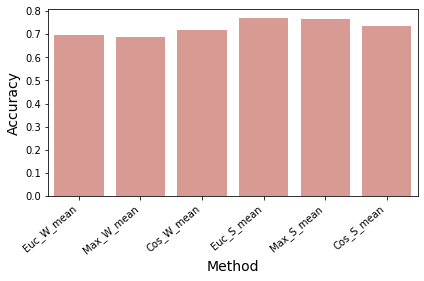

In [70]:
#sb.barplot(x=np.arange(len(b)), y=a, color="salmon")
ax=sb.barplot(data=c_df, color="salmon", saturation=0.5)
plt.xlabel("Method", size=14)
plt.ylabel("Accuracy", size=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()